# The Dissected Attention Network.

This notebook is based on the Pytorch ["Translation with a Sequence to Sequence Network and Attention"](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) tutorial by Sean Robertson. Most of the code is directly copied or only slightly modified. Some of the text cells are also copied directly from there.

We will build a basic sequence to sequence network with attention for language translation, while dissecting every function and class to learn the ins and outs of the attention mechanism.

This notebook is a byproduct of my learning process. I publish it in the hopes that someone may find some of the bits useful. It focuses on exploring seemingly basic segments that I myself didn't feel comfortable with, while it may skip over other important steps. Feel free to send me suggestions of improvement or clarification!

This is my first time using PyTorch, coming from a Keras background, so I will comment on some of my thoughts while using it.

In [46]:
# Lets import the stuff we will need
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
%matplotlib inline

## Loading data files

We will use french - english sentence pairs, which we can get from [here](https://download.pytorch.org/tutorial/data.zip).

In [2]:
# !wget -nc https://download.pytorch.org/tutorial/data.zip
# !unzip -n data.zip

This Lang class keeps track of the word to index dictionaries and word counts.

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Perform `unicode` -> `ascii` and a bit of data cleaning: lowercase, stripping, separating punctuation and remove non-letter-or-punctiation characters.




In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    # Separate punctuation from word by adding a space
    s = re.sub(r"([.!?])", r" \1", s)
    # Remove anything that isnt a letter or punctuation
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

The following function will read from the files and create the `Lang` objects. For me the confusing part here was the necessity of the reverse flag. Why not just exchange `lang1` and `lang2` when calling the function? The reason is that the files that we download are all English -> other language, so `lang1` here has to be English, and then you swap it.

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10853 sentence pairs
Counting words...
Counted words:
fra 4489
eng 2925
['vous regardez tout le temps la television .', 'you are always watching tv .']


Finally lets define here some utility functions to create tensors from sentences. Simple enough.

In [8]:
# A few utility functions to transform text into tensors
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Lets see what they look like. Seems like the `tensorFromSentence` function is already playing with the tensor shape, unsqueezing an extra empty dim at the end. I suppose this is the `embedding` dimension that will be populated by the `Embedding` layer later.

In [9]:
pair = random.choice(pairs)
t = tensorsFromPair(pair)
in_t = t[0]
out_t = t[1]
in_t, out_t, in_t.shape, out_t.shape

(tensor([[ 123],
         [ 298],
         [ 126],
         [ 247],
         [ 557],
         [1256],
         [   5],
         [   1]], device='cuda:0'),
 tensor([[ 77],
         [ 78],
         [148],
         [156],
         [693],
         [  4],
         [  1]], device='cuda:0'),
 torch.Size([8, 1]),
 torch.Size([7, 1]))

## The model

Here comes the untouched model code from the original tutorial, which we will then dissect to see what's going on.

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## Encoder Dissection

While reading the encoder code, I came up with two questions that I would like to answer: 
- Why is the `.view(1,1,-1)` necessary?
- Why do we initialize the hidden state with zeros?

In [12]:
# Parameters for testing
input_size = input_lang.n_words
hidden_size = 64

# Encoder has just two components
embedding = nn.Embedding(input_size, hidden_size)
gru = nn.GRU(hidden_size, hidden_size)

In [13]:
idx = indexesFromSentence(input_lang, pairs[0][0])
idx = torch.tensor(idx)
idx

tensor([2, 3, 4, 5])

In [14]:
embedded = embedding(idx)
embedded.shape

torch.Size([4, 64])

In [15]:
idx = idx.view(1,-1)
embedded = embedding(idx)
embedded.shape

torch.Size([1, 4, 64])

Seems like the embedding layer takes in whatever shape we please, and spits out a tensor with an appended `embedding` dimension. If we check the [documentation](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding), indeed it says: _"Input: `(\*)`, LongTensor of arbitrary shape containing the indices to extract"_. Neat!

The `GRU` however is stricter. Checking [its doc page](https://pytorch.org/docs/stable/nn.html?highlight=nn%20rnn#torch.nn.RNN), it turns out that PyTorch RNNs want a shape of `(seq, batch, H_in)`, instead of `(batch, seq, H_in)`, which is what I am used to as a Keras user.

In [16]:
# A `(seq, batch, H_in) tensor for the GRU
idx = indexesFromSentence(input_lang, pairs[0][0])
idx = torch.tensor(idx)
print(f"idx shape: {idx.shape}.")
embedded = embedding(idx)
embedded = embedded.unsqueeze(1) # Create batch dim
print(f"embedded shape: {embedded.shape}.")

idx shape: torch.Size([4]).
embedded shape: torch.Size([4, 1, 64]).


In [17]:
out,hidden = gru(embedded)
out.shape, hidden.shape

(torch.Size([4, 1, 64]), torch.Size([1, 1, 64]))

The `GRU` gives us an output tensor of the same shape as the input (because we gave it the same input and output size during initialization) and its last hidden state, which is why the `seq` dimension is empty there.

Now that we understand how the shapes work here, we can answer why we needed the `view(1,1,-1)` in the original script. It is very likely that during training, the encoder receives as input a rank 0 tensor containing only the index of a single word, which is transformed into a rank 1 tensor `(embedding)`, and finally the `view` inflates it into a `(seq, batch, embedding)`, where both `seq` and `batch` are 1. Seems like an interesting challenge at the end of this script could be to improve this to correctly pass tensors with filled `seq`s and `batch`es.

Lets also try to answer why we initialize with zeros by doing a little internet search.

A user on [stackexchange](https://datascience.stackexchange.com/questions/27225/how-what-to-initialize-the-hidden-states-in-rnn-sequence-to-sequence-models) highlights that it is important to distinguish between model weights, which will be updated through gradient descent, and states, which don't. There seem to be alternatives to zero initialization, but its the most commonly used one, so lets stick with it! 

## Decoder Dissection

On to the decoder! Lets follow the same pattern of initializing everthing and then playing around with it.

In [18]:
hidden_size = 64
out_size = output_lang.n_words

embedding = nn.Embedding(out_size, hidden_size)
attn = nn.Linear(hidden_size * 2, MAX_LENGTH)
attn_combine = nn.Linear(hidden_size * 2, hidden_size)
dropout = nn.Dropout(0.1)
gru = nn.GRU(hidden_size, hidden_size)
out_linear = nn.Linear(hidden_size, out_size)

In [19]:
# Since the decoder also works with just one sequence step,
# lets take just one element heer
idx = indexesFromSentence(input_lang, pairs[0][1][0])
idx = torch.tensor(idx)
embedded = embedding(idx).unsqueeze(1)
embedded.shape

torch.Size([1, 1, 64])

So far so good, we now have an embedded sequence. The idea behind attention is that we will create an additional input to our `GRU`, which is an attention vector, concatenated to target sequence.

In [20]:
# The decoder also assumes a context state with empty `seq`
# This guy comes from our encoder tests above
print(hidden.shape)
print(out.shape)

torch.Size([1, 1, 64])
torch.Size([4, 1, 64])


In [21]:
# The next thing that happens is a concatenation
concat = torch.cat((embedded[0], hidden[0]), 1)
concat.shape

torch.Size([1, 128])

What we have here is our embedded token together with the context vector of our encoder, so `(batch, hidden * 2)`. We will run this through a linear which will compress it into `(batch, max_seq)`. This is the core of the attention component.

The goal is to produce a vector that says _"this is how much you should pay attention to each of the outputs of the encoder, during the current decoding step"_. The information we let it take into account to judge this is the context vector and the current target token. 

Attention module talking: _"Looking at this context vector, which tells me more or less what the meaning of the input sentence was, and knowing you are currently at this target token in the prediction sequence, I can tell you that in order to produce the next output token, you better look at **this** particular part of the encoding sequence."_.  

In [22]:
attention = attn(concat)
attention.shape

torch.Size([1, 10])

In [23]:
# We need to turn it into a probability distribution,
# so we throw it through a softmax
attn_weights = F.softmax(attention, dim=1)
print(attn_weights.shape)
# We can check it adds up to one now
assert torch.abs(torch.sum(attn_weights.squeeze()) - 1) < 0.001

torch.Size([1, 10])


The decoder expects `encoder_outputs` to have a shape of `(seq, hidden)`, with `seq` of `MAX_LENGTH`, so lets build a fake one here.

After having a peek at the training loop, this is another thing that makes this code quite messy: the batch dim is now absent here again, although we artificially created one with the `view(1,1,-1)` at the encoder. The training loop will remove it, and later we will once again add a fake one. Lets stick to what they give us, for now.

In [24]:
out = torch.zeros([MAX_LENGTH, hidden_size])
out.shape

torch.Size([10, 64])

`torch.bmm` is a batch matrix product, which basically means it takes rank 3 tensors and interprets the first dim as a batch, and performs `torch.mm` on the two remaining dims.

Again, to me this line of code looks quite silly since we are adding an empty batch dimension to then use the `bmm` function. We could have used `mm` directly, and make it way easier to understand. In a real model where batches are treated with a bit more respect, `bmm` would be necessary though, which is why I assume they kept it here.

In [25]:
attn_applied = torch.bmm(attn_weights.unsqueeze(0), out.unsqueeze(0))
attn_applied.shape

torch.Size([1, 1, 64])

In [26]:
# Now we build the input for the GRU
gru_input = torch.cat((embedded[0], attn_applied[0]), 1)
gru_input.shape

torch.Size([1, 128])

We could technically use this already to feed it to the `gru`, but I suppose sticking a linear layer here helps reduce the size of the recurrent kernel. 

In [27]:
gru_input = F.relu(attn_combine(gru_input).unsqueeze(0))

Once again, we have unsqueezed to bring back the batch dim, which we need because `GRU` is grumpy about dimensions.

In [28]:
output, hidden = gru(gru_input, hidden)
output.shape, hidden.shape

(torch.Size([1, 1, 64]), torch.Size([1, 1, 64]))

In [29]:
# A final linear layer and we are done
output = F.log_softmax(out_linear(output[0]), dim=1)
output.shape

torch.Size([1, 2925])

Pfew. Lets see how the training loop is done, although now that we understand all the shapes, it shouldn't be much of an issue.

## Training Dissection

I will directly break things down here because the original functions are quite long. The goal is not to produce beautiful code but to play around with the internals, so lets get our knive ready.

In [30]:
# Initialize the models and variables
hidden_size = 256
lr = 0.001
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)
# Create encoder and decoder optimizers
encoder_optimizer = optim.SGD(encoder.parameters(), lr=lr)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=lr)

We gotta define our loss function. The models already contain a `log_softmax` function, so we have to pick the loss function that wants -log probabilities as input: `NLLLoss`. We could have used the `CrossentropyLoss`, which includes both the `log_softmax` and final loss calculation. 

In [31]:
criterion = nn.NLLLoss()

**Rerun from here** as many times as you want to manually perform training on your model.

In [32]:
# Grab some data to train with

# Grab random data
# pair = random.choice(pairs)
# input_sentence, output_sentence = pair
# input_tensor, target_tensor = tensorsFromPair(pair)

# Grab the same pair always to see the loss decrease
pair = pairs[88]
input_sentence, output_sentence = pair
input_tensor, target_tensor = tensorsFromPair(pair)

# Create the initial hidden state, shape: (1, 1, hidden_size)
encoder_hidden = encoder.initHidden()
# Reset the optimizer accumulated gradients
encoder_optimizer.zero_grad()
decoder_optimizer.zero_grad()
# Get seq length
input_length = input_tensor.size(0)
target_length = target_tensor.size(0)
# This is where we will keep the results of the encoder
encoder_outputs = torch.zeros(MAX_LENGTH, encoder.hidden_size, device=device)
# Set initial loss
loss = 0

Here we run the encoder manually with a for loop. I think it would have been possible to give the encoder a proper `seq` dimension and let it handle the loop internally, which would be much more efficient.

In [33]:
# Get the outputs from the encoder
for ei in range(input_length):
    encoder_output, encoder_hidden = encoder(
        input_tensor[ei], encoder_hidden)
    encoder_outputs[ei] = encoder_output[0, 0]

In [34]:
# Tensor that will hold decoder inputs
decoder_input = torch.tensor([[SOS_token]], device=device)

Now, in the code they do a mix of teacher forcing and regular training. Teacher forcing means that you use the true target sequence as input for the decoder, using the outputs only to compute the loss.

In regular training, the output of the decoder at each timestep is used as input for the next iteration. Both seem to have advantages and disadvantages, so using fifty fifty of both results is an interesting compromise. Lets go with teacher forcing here, though both are very similarly implemented.

In [35]:
# Pass over the context 
decoder_hidden = encoder_hidden

Lets keep track of the attention weights, for later visualizing them.

In [36]:
decoder_attentions = torch.zeros(MAX_LENGTH, MAX_LENGTH)

Lets also keep track of the decoded words that the decoder predicts.

In [37]:
decoded_words = []

I would need to investigate on how to avoid a for loop for the decoder. That seems to be more difficult since there are a lot of steps to perform between each iteration.

In [38]:
for di in range(target_length):
    decoder_output, decoder_hidden, decoder_attention = decoder(
        decoder_input, decoder_hidden, encoder_outputs)
    loss += criterion(decoder_output, target_tensor[di])
    decoder_attentions[di] = decoder_attention
    decoder_input = target_tensor[di]
    topv, topi = decoder_output.data.topk(1)
    if topi.item() == EOS_token:
        decoded_words.append('<EOS>')
        break
    else:
        decoded_words.append(output_lang.index2word[topi.item()])
    

Now the loss is accumulated in the `loss` variable, and we can call the PyTorch `backward` function to perform a calculation of all our gradients. After calling this function, according to PyTorch docs, the graph that was created during the forwards pass is "freed", which means we cannot call `backward` a second time. We first have to reset the weights and perform another forward pass.

Something interesting that happened here is that, although our `loss` was initialized as an integer (`loss = 0`), as soon as we run the line `loss += criterion(...)`, the `int` will be promoted to a PyTorch tensor, which has the method `backward`.

In [39]:
loss.backward()
print(loss)

tensor(40.0643, device='cuda:0', grad_fn=<AddBackward0>)


In [40]:
# Perform a weight update
encoder_optimizer.step()
decoder_optimizer.step()

If we run the cells between the cell marked above as "rerun from here" to here, we should see the average loss dropping over time. However, as we are grabbing a random sentence every time, there are big changes in the values each iteration. You can comment out that line and uncomment the one where we take the same value every time. The model will of course overfit on a single sequence, but we will be able to see the loss dropping consistently, which is pleasant to see after dissected the whole thing and made it run "manually".

## Extra! Visualizing the attention weights

The decoder implemented by the original notebook already returns the attention weights, which we have caught above during training, and can plot with `matplotlib`.


In [41]:
from matplotlib import pyplot as plt
from matplotlib import ticker

In [42]:
attention = decoder_attentions.detach().cpu().numpy()
attention.shape

(10, 10)

Of course, unless we are using a properly trained model, these will look quite random.

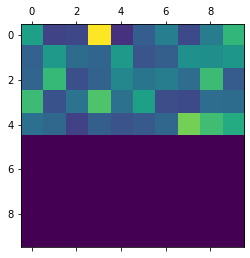

In [43]:
plt.matshow(attention)

For a more pleasant experience, where we label the axis with the actual words that composed the sentence, we can do something like the following.

The predicted sentence would of course again be quite nonsensical since we did not train our model properly.

In [44]:
# Input, output and predicted sentences
print(input_sentence)
print(output_sentence)
print(decoded_words)

je suis saoul .
i m drunk .
['chances', 'runner', 'bear', 'interpreter', 'suddenly']


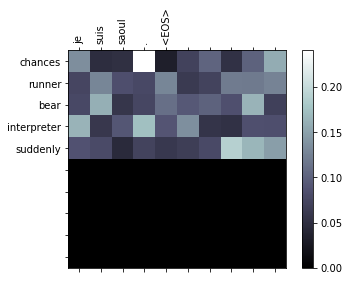

In [45]:
# Set up figure with colorbar
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(attention, cmap='bone')
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + input_sentence.split(' ') +
                   ['<EOS>'], rotation=90)
ax.set_yticklabels([''] + decoded_words)

# Show label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()